In [1]:
# Import required libraries
# !pip install torch transformers datasets sentencepiece matplotlib
import importlib
import subprocess

def install_if_missing(package):
    try:
        importlib.import_module(package)
    except ImportError:
        subprocess.check_call(["pip", "install", package])

# Ensure necessary libraries are installed
install_if_missing("torch")
install_if_missing("transformers")
install_if_missing("datasets")
install_if_missing("sentencepiece")
install_if_missing("matplotlib")

import torch
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM, AdamW, DataCollatorWithPadding
from datasets import load_dataset
import matplotlib.pyplot as plt

In [2]:
# Set device to CPU
# device = torch.device("cpu")

In [3]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Load datasets
parallel_dataset = load_dataset("Helsinki-NLP/opus-100", "en-hi")
mono_dataset = load_dataset("oscar", "unshuffled_deduplicated_hi", split="train")

# Check dataset structure
print(parallel_dataset)
print(mono_dataset)

# Select subsets for training
train_parallel = parallel_dataset['train'].select(range(10000))
mono_data = mono_dataset.select(range(20000))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/65.4k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/259k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/65.2M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/247k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/534319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/303k [00:00<?, ?B/s]

oscar.py:   0%|          | 0.00/14.8k [00:00<?, ?B/s]

The repository for oscar contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/oscar.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/1909387 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/20 [00:00<?, ?it/s]

DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 534319
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})
Dataset({
    features: ['id', 'text'],
    num_rows: 1909387
})


In [14]:
# Load and configure GPT-2 model
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2").to(device)

# Enable gradient checkpointing (after loading the model)
model.gradient_checkpointing_enable()

tokenizer.add_special_tokens({"pad_token": "[PAD]"})
model.resize_token_embeddings(len(tokenizer))


Embedding(50258, 768)

In [15]:
print(type(model))


<class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'>


In [6]:
# Preprocess parallel data for translation
def preprocess_parallel(examples):
    inputs = [f"Translate Hindi to English: {ex['hi']}" for ex in examples["translation"]]
    targets = [ex['en'] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, padding="max_length", max_length=128, truncation=True)
    labels = tokenizer(targets, padding="max_length", max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

parallel_data = train_parallel.map(preprocess_parallel, batched=True)

# Preprocess monolingual Hindi data
def preprocess_mono(examples):
    inputs = examples["text"]
    model_inputs = tokenizer(inputs, padding="max_length", max_length=128, truncation=True)
    return model_inputs

processed_mono_data = mono_data.map(preprocess_mono, batched=True)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [10]:
import torch
from torch.utils.data import DataLoader
import torch.nn.utils.rnn as rnn_utils
from transformers import AdamW

In [11]:
# Collate function with padding and device assignment
def collate_batch(batch):
    input_ids = rnn_utils.pad_sequence(
        [torch.tensor(item["input_ids"]) for item in batch],
        batch_first=True,
        padding_value=tokenizer.pad_token_id
    ).to(device)

    attention_mask = (input_ids != tokenizer.pad_token_id).to(device)
    return input_ids, attention_mask

# DataLoader (set num_workers=0 for CUDA compatibility)
mono_loader = DataLoader(
    processed_mono_data,
    batch_size=64,
    shuffle=True,
    collate_fn=collate_batch,
    num_workers=0  # Avoid multiprocessing issues with CUDA
)


In [16]:
# Optimize model with torch.compile (optional for speed-up)
model = model.to(device)
model.gradient_checkpointing_enable()
model = torch.compile(model)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)


In [17]:
# Autoencoder Pretraining Loop
autoencoder_losses = []
epochs = 3
gradient_accumulation_steps = 4

model.train()
for epoch in range(epochs):
    total_loss = 0

    for step, (inputs, attention_mask) in enumerate(mono_loader):
        outputs = model(input_ids=inputs, attention_mask=attention_mask, labels=inputs)
        loss = outputs.loss / gradient_accumulation_steps

        # Backward pass
        loss.backward()

        if (step + 1) % gradient_accumulation_steps == 0 or (step + 1) == len(mono_loader):
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item() * gradient_accumulation_steps

    avg_loss = total_loss / len(mono_loader)
    autoencoder_losses.append(avg_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Autoencoder Loss: {avg_loss}")

# Save the pretrained model
model.save_pretrained("optimized_autoencoder_hindi")
tokenizer.save_pretrained("optimized_autoencoder_hindi")


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 1/3, Autoencoder Loss: 1.891507047814683
Epoch 2/3, Autoencoder Loss: 1.7103031226240408
Epoch 3/3, Autoencoder Loss: 1.604593220229347


('optimized_autoencoder_hindi/tokenizer_config.json',
 'optimized_autoencoder_hindi/special_tokens_map.json',
 'optimized_autoencoder_hindi/vocab.json',
 'optimized_autoencoder_hindi/merges.txt',
 'optimized_autoencoder_hindi/added_tokens.json',
 'optimized_autoencoder_hindi/tokenizer.json')

In [20]:
# Fine-Tuning on Parallel Data
from transformers import AutoModelForCausalLM, AutoTokenizer
from torch.utils.data import DataLoader
import torch.nn.utils.rnn as rnn_utils
import torch

# Load the pre-trained autoencoder
model = AutoModelForCausalLM.from_pretrained("optimized_autoencoder_hindi").to(device)
tokenizer = AutoTokenizer.from_pretrained("optimized_autoencoder_hindi")

# Prepare parallel data
parallel_data = train_parallel.map(preprocess_parallel, batched=True)

def collate_parallel_batch(batch):
    input_ids = rnn_utils.pad_sequence(
        [torch.tensor(item["input_ids"]) for item in batch],
        batch_first=True,
        padding_value=tokenizer.pad_token_id
    ).to(device)

    attention_mask = (input_ids != tokenizer.pad_token_id).to(device)

    labels = rnn_utils.pad_sequence(
        [torch.tensor(item["labels"]) for item in batch],
        batch_first=True,
        padding_value=-100  # Ignore padding tokens in the loss calculation
    ).to(device)

    return input_ids, attention_mask, labels

# DataLoader
parallel_loader = DataLoader(
    parallel_data,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_parallel_batch,
    num_workers=0
)

# Fine-Tuning Loop
fine_tuning_losses = []
epochs = 3
gradient_accumulation_steps = 4

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

model.train()
for epoch in range(epochs):
    total_loss = 0

    for step, (inputs, attention_mask, labels) in enumerate(parallel_loader):
        outputs = model(input_ids=inputs, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss / gradient_accumulation_steps

        loss.backward()

        if (step + 1) % gradient_accumulation_steps == 0 or (step + 1) == len(parallel_loader):
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item() * gradient_accumulation_steps

    avg_loss = total_loss / len(parallel_loader)
    fine_tuning_losses.append(avg_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Fine-Tuning Loss: {avg_loss}")

# Save the fine-tuned model
model.save_pretrained("hindi_to_english_gpt2")
tokenizer.save_pretrained("hindi_to_english_gpt2")


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Epoch 1/3, Fine-Tuning Loss: 1.6188741277772398
Epoch 2/3, Fine-Tuning Loss: 0.917594425784894
Epoch 3/3, Fine-Tuning Loss: 0.8929512367461817


('hindi_to_english_gpt2/tokenizer_config.json',
 'hindi_to_english_gpt2/special_tokens_map.json',
 'hindi_to_english_gpt2/vocab.json',
 'hindi_to_english_gpt2/merges.txt',
 'hindi_to_english_gpt2/added_tokens.json',
 'hindi_to_english_gpt2/tokenizer.json')

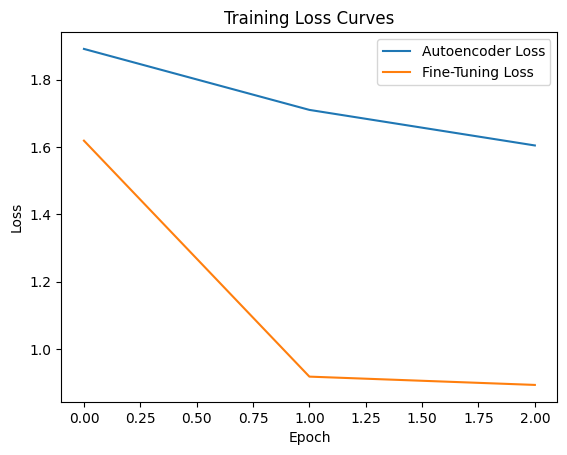

In [21]:

# Plotting Loss Curves
import matplotlib.pyplot as plt

plt.plot(autoencoder_losses, label="Autoencoder Loss")
plt.plot(fine_tuning_losses, label="Fine-Tuning Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss Curves")
plt.show()

In [24]:
# Ensure proper padding and truncation
collator = DataCollatorWithPadding(tokenizer)

# Extract and preprocess parallel dataset properly
def preprocess_parallel(examples):
    inputs = [f"Translate Hindi to English: {ex['hi']}" for ex in examples["translation"]]
    targets = [ex['en'] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, padding="max_length", max_length=128, truncation=True)
    labels = tokenizer(targets, padding="max_length", max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

parallel_data = train_parallel.map(preprocess_parallel, batched=True, remove_columns=train_parallel.column_names)

# Ensure the dataset is compatible with DataLoader
train_loader = DataLoader(parallel_data, batch_size=8, shuffle=True, collate_fn=collator)

contrastive_losses = []

# Contrastive loss function
def contrastive_loss(pos, neg, temp=0.1):
    pos_sim = torch.cosine_similarity(pos, pos, dim=-1)
    neg_sim = torch.cosine_similarity(pos, neg, dim=-1)
    return -torch.log(torch.exp(pos_sim / temp) / (torch.exp(pos_sim / temp) + torch.exp(neg_sim / temp))).mean()

# Contrastive Learning Loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass with hidden states for contrastive loss
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels, output_hidden_states=True)
        loss = outputs.loss

        # Positive embeddings from the last hidden layer
        positive_embeddings = outputs.hidden_states[-1].mean(dim=1)

        # Generate perturbed (negative) input
        noise = (torch.randn_like(input_ids.float()) * 0.01).to(device)
        perturbed_input = (input_ids.float() + noise).long().clamp(0, tokenizer.vocab_size - 1)

        # Ensure shape and range match
        perturbed_input = perturbed_input[:, :input_ids.shape[1]]

        # Obtain negative embeddings without gradient calculation
        with torch.no_grad():
            negative_outputs = model(input_ids=perturbed_input, attention_mask=attention_mask, output_hidden_states=True)
            negative_embeddings = negative_outputs.hidden_states[-1].mean(dim=1)

        # Compute contrastive loss
        cl_loss = contrastive_loss(positive_embeddings, negative_embeddings)

        # Combine main loss with contrastive loss
        combined_loss = loss + 0.1 * cl_loss

        # Backpropagation
        optimizer.zero_grad()
        combined_loss.backward()
        optimizer.step()

        total_loss += combined_loss.item()

    # Store average loss for visualization
    contrastive_losses.append(total_loss / len(train_loader))
    print(f"Epoch {epoch + 1}/{epochs}, Contrastive Loss: {total_loss / len(train_loader):.4f}")


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Epoch 1/3, Contrastive Loss: 0.9309
Epoch 2/3, Contrastive Loss: 0.9056
Epoch 3/3, Contrastive Loss: 0.8920


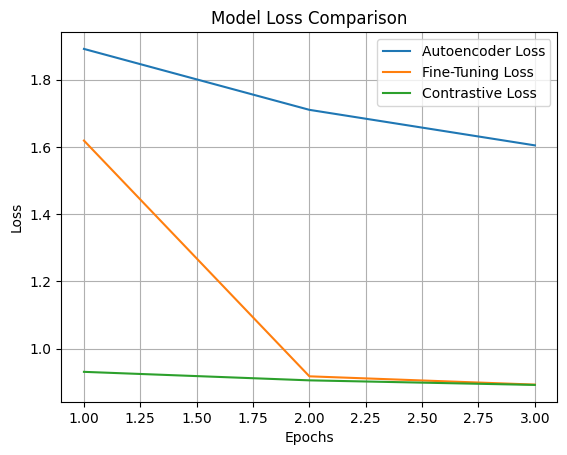

In [26]:
# Visualizing Loss Trends
plt.plot(range(1, epochs + 1), autoencoder_losses, label='Autoencoder Loss')
plt.plot(range(1, epochs + 1), fine_tuning_losses, label='Fine-Tuning Loss')
plt.plot(range(1, epochs + 1), contrastive_losses, label='Contrastive Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss Comparison")
plt.legend()
plt.grid(True)
plt.show()